In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os
import missingno as msno

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

from src.utils import show_feature_importances

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data_path='./data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
payments_data = pd.read_csv(os.path.join(data_path, "payments.csv"))

print("payments_data.shape = {} rows, {} cols".format(*payments_data.shape))

payments_data.shape = 1023932 rows, 8 cols


In [4]:
payments_data.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [5]:
payments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [6]:
payments_data.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,1.236018e+08,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.027412e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,1.234233e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,1.235130e+08,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.236020e+08,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.236910e+08,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.237796e+08,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


In [7]:
for col in payments_data.columns[2:]:
    print(f'{col}: n_uniques:{payments_data[col].nunique()} list:{payments_data[col].unique()}')

NUM_INSTALMENT_VERSION: n_uniques:44 list:[  1.   0.   5.   2.  11.  17.   3.   8.   4.   9.   6.  10.   7.  20.
  15.  18.  13.  14.  43.  21.  12.  25.  29.  34.  26.  31.  16.  27.
  19.  42.  24.  22.  23.  33.  35.  39.  37.  28.  45.  32.  38.  30.
  40. 178.]
NUM_INSTALMENT_NUMBER: n_uniques:243 list:[  5  13  10  82  63  49   2  97  67   9   4  20  76   6   3  21   7   8
   1  22  12  96  50  14  32  11  18  16  29 120  35  24  31  34  41  26
  37  23  93  39  48  90  87  91  53  45  17  95  79  85  47  40  62  38
  71  57  98  46  15  77  27 107 106  25  73  19 102 101  88  72 135  75
  65  83  59  61  89 185 113  43  56  28 121  60  86  81  66 108  52  30
 110 112  74 122  44  68 111  92  51 165  69  70 114 124 150  58 119  36
  42 127 132 180  54  64  84 105 100  33  94  78 175 109 123  99 117  55
 149 104 181  80 134 151 130 148 147 126 155 125 169 167 140 103 115 116
 158 166 170 131 118 139 177 161 164 144 133 188 137 202 142 146 141 154
 209 128 129 160 145 138 136 198 1

In [8]:
data = payments_data.merge(train_data[['APPLICATION_NUMBER', 'TARGET']], how='left', on='APPLICATION_NUMBER')
data = data.dropna(subset=['TARGET'])
data = data.reset_index(drop=True)

In [9]:
data.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,TARGET
0,49275338,123519263,1.0,2,831.0,850.0,2645.775,2645.775,0.0
1,49628418,123689202,1.0,22,1156.0,1156.0,8748.360,8748.360,0.0
2,48445013,123642687,1.0,12,340.0,350.0,23731.740,23731.740,0.0


In [10]:
numerical_features = data.drop(['APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns

<AxesSubplot:>

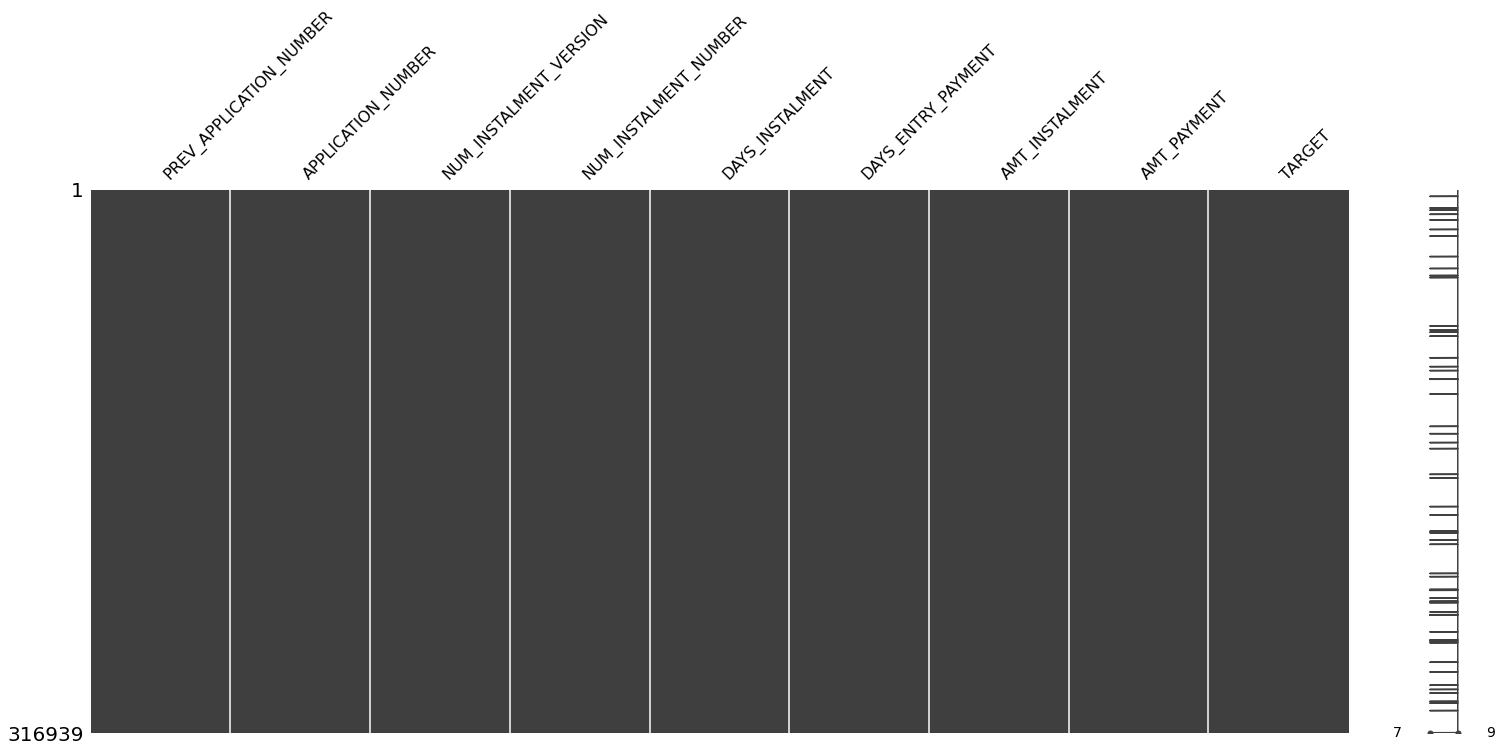

In [11]:
msno.matrix(data)

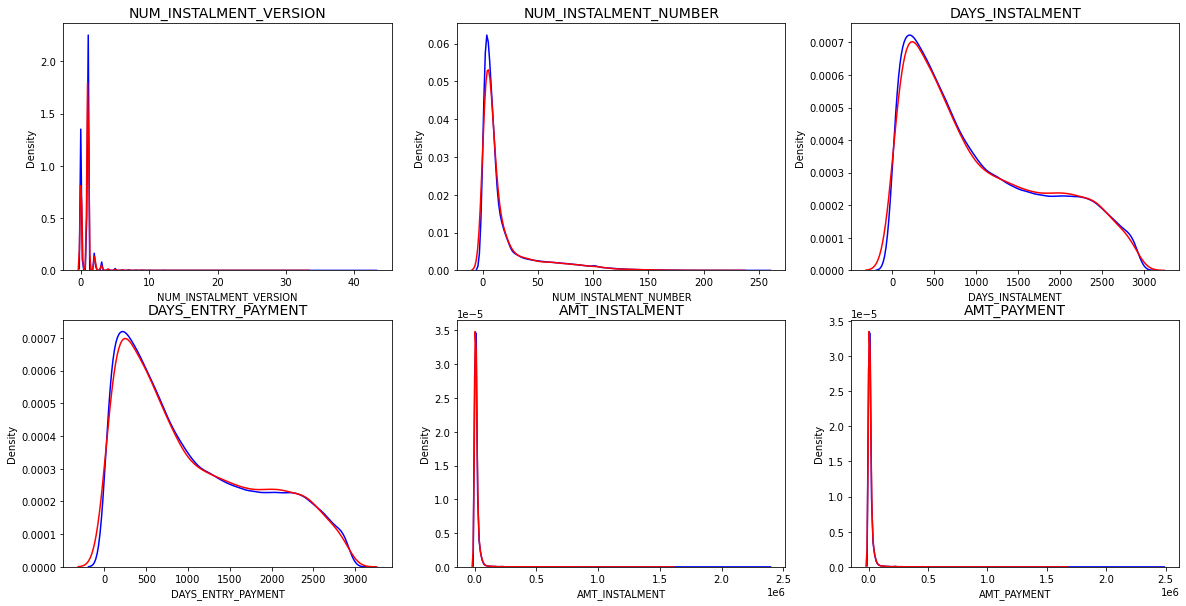

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for num, feature in enumerate(numerical_features):
    try:
        train_target_0, test_target_1 = data[data['TARGET']==0][feature].copy(), data[data['TARGET']==1][feature].copy()
        sns.kdeplot(train_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(test_target_1, ax=axes[num//3, num%3], color="red", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//3, num%3].set_title(feature, fontsize=14)

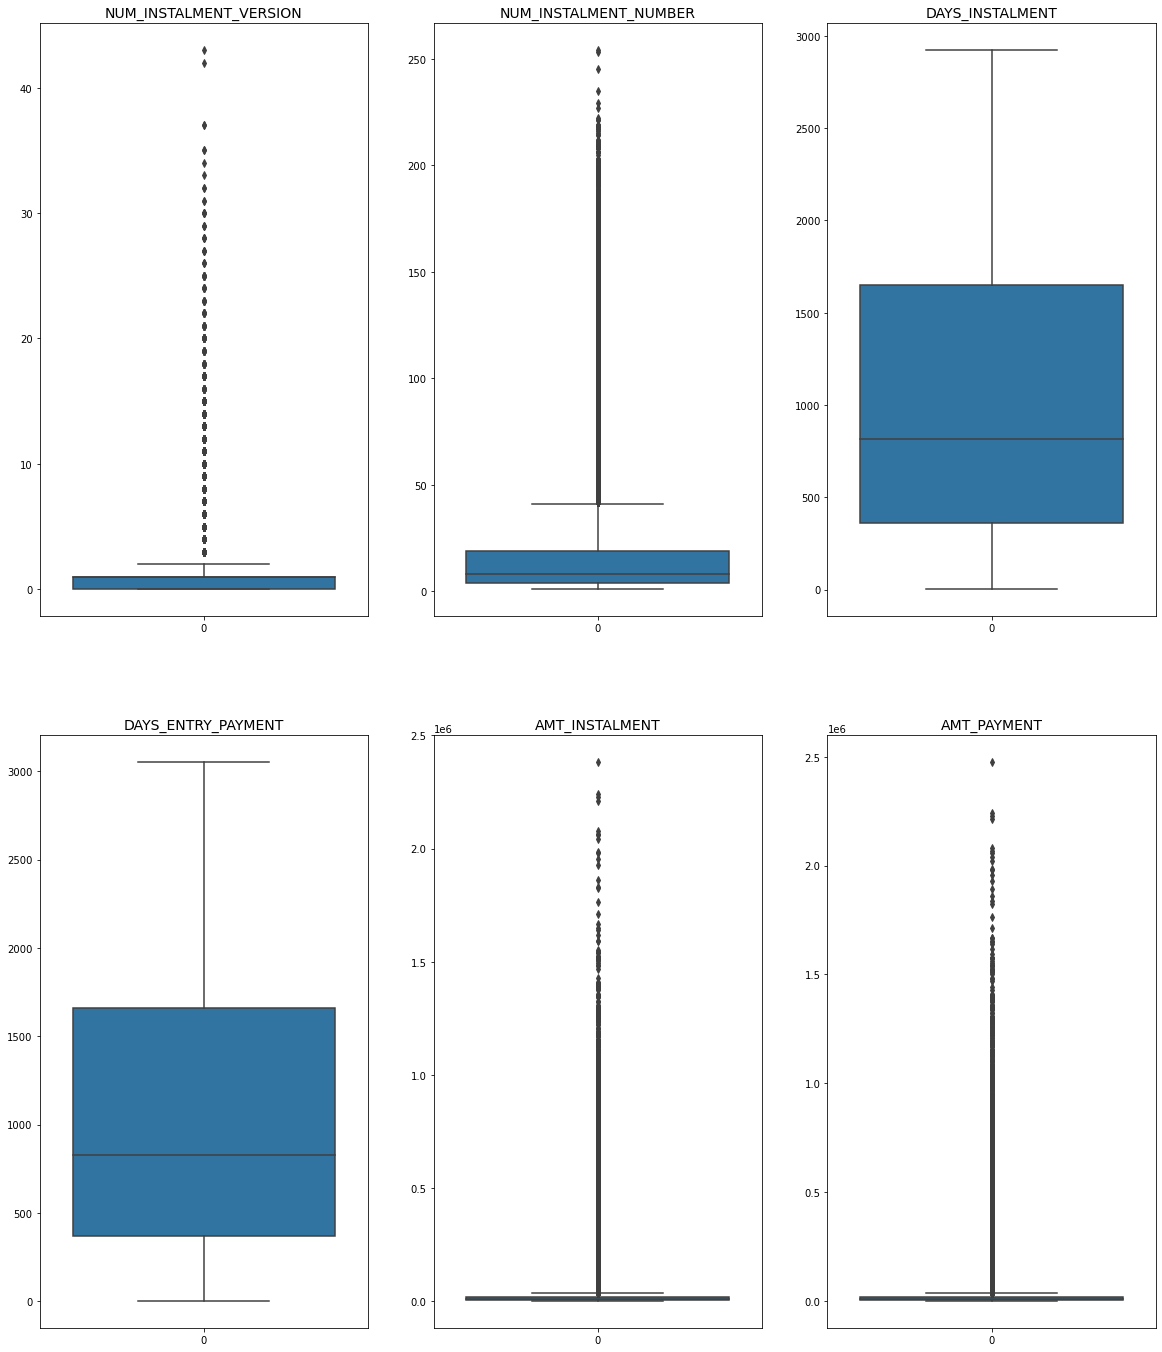

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 24))

for num, feature in enumerate(numerical_features):
    try:
        sns.boxplot(data=data[feature], ax=axes[num//3, num%3])
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//3, num%3].set_title(feature, fontsize=14)

### correlation

In [15]:
correlation = data.corr()

<AxesSubplot:>

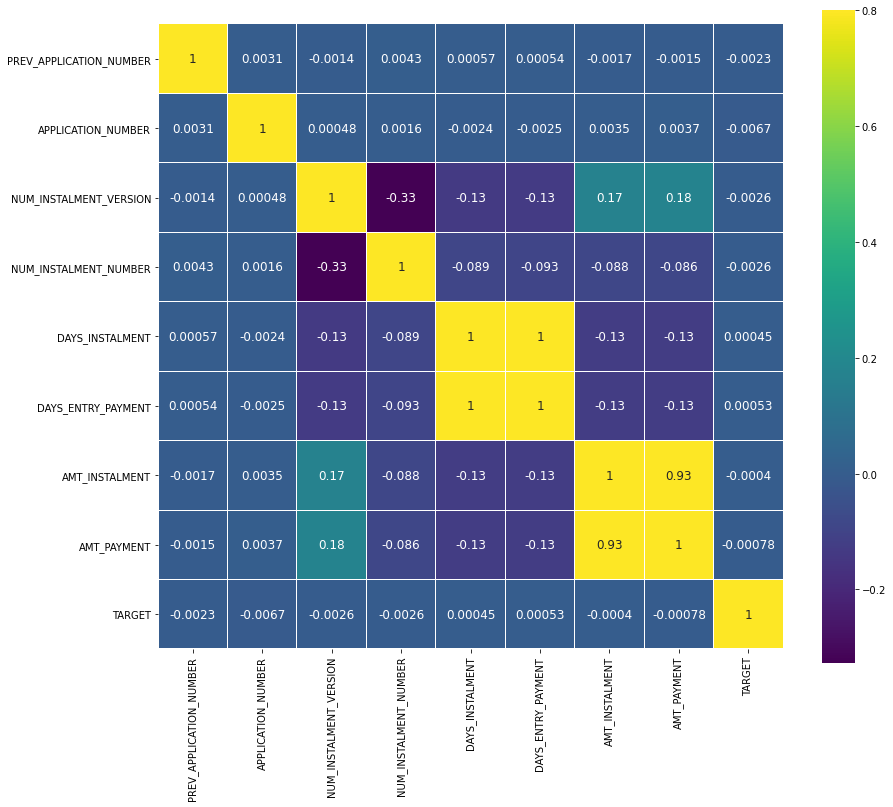

In [16]:
fig, axes = plt.subplots(figsize = (14, 12))
sns.heatmap(
    correlation,
    vmax=0.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=correlation.columns,
    annot_kws = {"size": 12},
    yticklabels=correlation.columns
)